# Analyse descriptive 1 
### Base : Centrales Nucléaires en France métropolitaine 

Objectifs: Nous voulons intégrer le risque lié au nucléaire dans la cartographie des risques d'une habitation.

Nous avons donc recherché les normes existantes auprès de l'Autorité de Sureté Nucléaire. Les différentes zones de surveillance sont délimitées selon la distance à vol d'oiseau d'une habitation à une centrale. 

Nous voulons alors connaître le degré d'exposition à ce "risque" du territoire français. L'intérêt est d'évaluer la proportion de la population française vivant à proximité d'une centrale nucléaire. 

Nous intégrerons ensuite la mesure de ce risque à notre projet dans l'évaluation de l'exposition d'une habitation aux risques naturels. 
 

####Installation des packages nécessaires à l'étude descriptive 

In [3]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 29.0 MB/s 
     |████████████████████████████████| 16.7 MB 50.7 MB/s 
     |████████████████████████████████| 6.3 MB 47.5 MB/s 


In [4]:
pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 


In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
import geopandas as gpd
import contextily as ctx

In [7]:
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 28.0 MB/s 
     |████████████████████████████████| 140 kB 21.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 6.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 138 kB 58.1 MB/s 
     |████████████████████████████████| 357 kB 52.7 MB/s 
     |████████████████████████████████| 2.3 MB 59.7 MB/s 
     |████████████████████████████████| 379 kB 49.4 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 5.2 MB/s 
     |████████████████████████████████| 9.1 MB 45.3 MB/s 
  Using cached urllib3-1.26.13-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.22
    Uninstalling urllib3-1.22:
      Successfully uninstalled urllib3-1.22
  Attempting uninstall: botocore
    Found existing installation: botocore

Cloning into 'cartogether'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 314 (delta 95), reused 137 (delta 56), pack-reused 104
Receiving objects: 100% (314/314), 3.96 MiB | 19.87 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/cartogether
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 24.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/cartogether
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for UNKNOWN: filename=UNKNOWN-0.0.0-py3-none-any.whl size=19403 sha256=4ce05459733ddd7fd6930aa19c82a752a6cb107fe7896d5bf0e8720c412306b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-2y3zzoqo/wheels/a6/05/bc/3f2d20b908a713d0bafbaff0170050d02aafcc4c2cacdd7677
Successfully built UNKNOWN


####Analyse descriptive : base "Centrales Nucléaires"

**II/ Visualisation et description de la base "Centrales Nucléaire"**

La base "centrales" comportent des informations sur chacune des centrales nucléaires de France métropolitaine. 

Celle qui nous intéressent correspondent aux données géographiques (latitude, longitude, commune, département) 

In [8]:
centrales = pd.read_csv("/content/centrales_nucleaires.csv",sep=',',encoding_errors='ignore')

#Conversion des coordonnées GPS d'un point en une géométrie exploitable sur Geopandas 
geometry = gpd.points_from_xy(centrales["Commune long"], centrales["Commune Lat"])

#Création d'un dataframe avec geométrie du point à localiser 
geo_centrales = gpd.GeoDataFrame(centrales, crs="EPSG:4326", geometry=geometry)
geo_centrales.crs

geo_centrales.head()

,Centrale nuclaire,Nombre de racteur,Commune,Commune Lat,Commune long,Dpartement,Rg,Palier,Puissance thermique (MWt),Puissance brute (MWe),Puissance nette (MWe),Dbut construction (premier racteur),Raccordement au rseau (premier racteur),Mise en service (premier racteur),geometry
0,Belleville,2,Belleville,47.507221,2.849960,Cher,54,P'4,7634,2726,2620,1980,1987,1988,POINT (2.84996 47.50722)
1,Blayais,4,Braud-et-Saint-Louis,45.247987,-0.626174,Gironde,32,CP1,11140,3804,3640,1977,1981,1981,POINT (-0.62617 45.24799)
2,Bugey,4,Saint-Vulbas,45.832913,5.290324,Ain,13,CP0,11140,3724,3580,1972,1978,1979,POINT (5.29032 45.83291)
3,Cattenom,4,Cattenom,49.406263,6.243668,Moselle,50,P'4,15268,5448,5200,1979,1986,1987,POINT (6.24367 49.40626)
4,Chinon-B,4,Avoine,47.205697,0.181982,Indre-et-Loire,40,CP2,11140,3816,3620,1977,1982,1984,POINT (0.18198 47.20570)


**III/ Répartition géographique des centrales nucléaires sur le territoire de France métropolitaine**

Les 19 centrales sont représentées, localisées très souvent le long ou proche d'un fleuve (également proche d'une grande ville). 

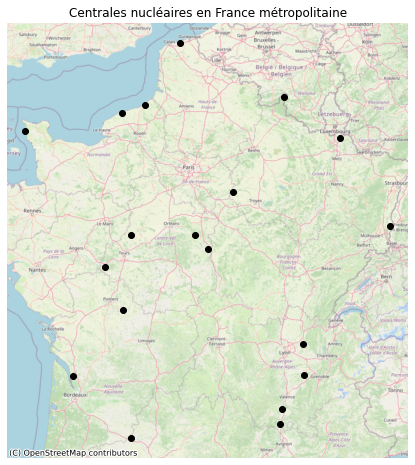

In [9]:
base = geo_centrales.to_crs(3857).plot(color='black',figsize=(8,8))
base.set_axis_off()
base.set_title("Centrales nucléaires en France métropolitaine")
ctx.add_basemap(base,source=ctx.providers.OpenStreetMap.Mapnik)

**IV/ Population exposée au risque nucléaire**

**La mesure du risque lié au nucléaire que nous avons choisie se base sur les normes établies par les autorités:** 


*   Zone d'évacuation : rayon de 5km autour de la centrale 
*   Zone PPI (plan particulier d'intervention) : rayon de 20km 
*   Zone de contamination (basée sur Fukushima) : rayon de 60km 
*   Zone correspondant aux recommandations d'évacuation des Etats-Unis : rayon de 80km 
*   Zone élargie de PPI demandé par GreenPeace : rayon de 100km 

On calcule alors un risque (évalué de 1 à 5) selon la proximité géographique d'une habitation à une centrale nucléaire. 

Par exemple, si on considère une zone de couverture de 50km de rayon autour de chaque centrale nucléaire :

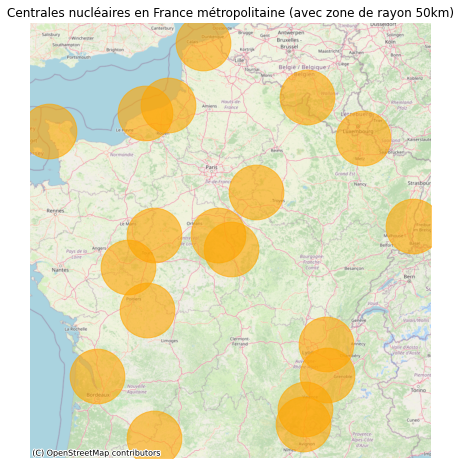

In [10]:
base = geo_centrales.to_crs(3857).plot(alpha=0.6,color='orange',markersize=3000,figsize=(8,8))
base.set_axis_off()
base.set_title("Centrales nucléaires en France métropolitaine (avec zone de rayon 50km)")
ctx.add_basemap(base, source=ctx.providers.OpenStreetMap.Mapnik)

In [11]:
#Nombre de centrales nucléaires par département 
centrales["Dpartement"].value_counts()

Seine-Maritime     2
Cher               1
Gironde            1
Loir-et-cher       1
Isre               1
Aube               1
Nord               1
Tarn-et-Garonne    1
Manche             1
Haut-Rhin          1
Loiret             1
Ardche             1
Vienne             1
Ardennes           1
Indre-et-Loire     1
Moselle            1
Ain                1
Drme               1
Name: Dpartement, dtype: int64

#### Dataset : communes de france métropolitaine, population et coordonnées GPS 

In [14]:
#Base --> lien entre la population par communes de France métropolitaine et leurs coordonnées GPS 
pop = pd.read_csv("/content/adresses.csv")
pop.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,departement,slug,nom_reel,nom_soundex,nom_metaphone,cp,num_commune,nb_cp,...,densite_2012,superficie,longitude_degre,latitude_degre,longitude_grd,latitude_grd,longitude_dms,latitude_dms,altitude_min,altitude_max
0,0,1,1,ozan,Ozan,O250,OSN,1190,284,0,...,75.757576,6.60,4.91667,46.3833,2866.0,51546.0,45456.0,462330.0,170.0,205.0
1,1,2,1,cormoranche-sur-saone,Cormoranche-sur-Saône,C65652625,KRMRNXSRSN,1290,123,0,...,101.522843,9.85,4.83333,46.2333,2772.0,51379.0,44953.0,461427.0,168.0,211.0
2,2,3,1,plagne-01,Plagne,P425,PLKN,1130,298,0,...,16.129032,6.20,5.73333,46.1833,3769.0,51324.0,54342.0,461131.0,560.0,922.0
3,3,4,1,tossiat,Tossiat,T230,TST,1250,422,0,...,137.659784,10.17,5.31667,46.1333,3309.0,51268.0,51854.0,460828.0,244.0,501.0
4,4,5,1,pouillat,Pouillat,P430,PLT,1250,309,0,...,16.051364,6.23,5.43333,46.3333,3435.0,51475.0,52542.0,461938.0,333.0,770.0


In [15]:
#Nombre de communes en France métropolitaine 
pop.shape

(36700, 24)

####Fonctions nécessaire pour évaluer la proportion de la population dans chacune des zones de surveillance nucléaire 

In [16]:
#Conversion des coordonnées GPS d'un point en une géométrie exploitable sur Geopandas 
geome = gpd.points_from_xy(pop["longitude_degre"], pop["latitude_degre"])

#Création d'un dataframe avec geométrie du point à localiser 
geo_pop = gpd.GeoDataFrame(pop, crs="EPSG:4326", geometry=geome)
geo_pop.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
#Fonction geometry ->risque 
def risque(centrales_geo_k): #geometry = la zone d'évacuation considérée autour d'une centrale nucléaire 
  risque=[]
  for k in range(len(geo_pop["geometry"])):
    if centrales_geo_k.contains(geo_pop["geometry"][k]):
      risque.append(geo_pop["pop_2012"][k])
  
  return(risque)

In [18]:
def pop_exposee(centrales_geo):
  pop_exposee = []
  for i in range(19) :
    pop_exposee.append(sum(risque(centrales_geo[i])))
  return(pop_exposee)

In [19]:
#Liste avec le nombre de personnes habitant dans une zone de 5km autour de chaque centrale nucléaire 
pop_risque5km = pop_exposee(geo_centrales.buffer(5/1.2*(1/60)))
#Liste avec le nombre de personnes habitant dans une zone de 20km autour de chaque centrale nucléaire 
pop_risque20km = pop_exposee(geo_centrales.buffer(20/1.4*(1/60))) 
#Liste avec le nombre de personnes habitant dans une zone de 60km autour de chaque centrale nucléaire 
pop_risque60km = pop_exposee(geo_centrales.buffer(60/1.6*(1/60))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [20]:
#Population totale habitant dans une zone de 5km, 20km ou 60km autour d'une centrale nucléaire 
total = np.array(["total",sum(pop_risque5km),sum(pop_risque20km),sum(pop_risque60km)])
pop_totale = pd.DataFrame(total)
pop_totale = pop_totale.set_index(pd.Index(["Centrale","5km","20km","60km"])).transpose()
print(pop_totale)

  Centrale     5km     20km      60km
0    total  199000  2170000  18117300


#### Population habitant dans une zone de 5km, 20km ou 60km autour d'une centrale nucléaire 

In [50]:
#Création dataframe pour visualiser le nombre de personne dans une zone à risque pour chacune des centrales 
pop_risquenucleaire = pd.DataFrame(data={'Centrale': centrales["Centrale nuclaire"], '5km': pop_risque5km, '20km': pop_risque20km, '60km': pop_risque60km})
pop_risquenucleaire = pd.concat([pop_risquenucleaire,pop_totale],axis=0,join='inner')
pop_risquenucleaire.head(20)

,Centrale,5km,20km,60km
0,Belleville,8100,66300,535400
1,Blayais,9600,93500,1421500
2,Bugey,6200,191800,2543900
3,Cattenom,13100,285400,971200
4,Chinon-B,11300,82300,917900
5,Chooz-B,11100,27900,229600
6,Civaux,6700,66200,553700
7,Cruas,10900,162000,941700
8,Dampierre,15500,94600,579100
9,Fessenheim,7400,148400,989600


In [39]:
pop_risquenucleaire1 = pd.DataFrame(data={'5km': pop_risque5km, '20km': pop_risque20km, '60km': pop_risque60km})

In [52]:
pop_risquenucleaire1.style.background_gradient(cmap='Reds',)

,5km,20km,60km
0,8100,66300,535400
1,9600,93500,1421500
2,6200,191800,2543900
3,13100,285400,971200
4,11300,82300,917900
5,11100,27900,229600
6,6700,66200,553700
7,10900,162000,941700
8,15500,94600,579100
9,7400,148400,989600


**Commentaire:**

*   Certaines centrales nucléaires sont davantages situées près de zones fortement peuplées que d'autres (ex: celles de Gravelines ou de Dampierre)
*   Les zones de rayon 60km autour des centrales concentrent pour certaines près de 2 millions de personnes (2,5millions pour la centrale de Bugey)

Il y a des disparités géographiques de densité de population autour des différentes centrales nucléaires qu'il est possible d'exploiter pour cartographier le risque lié au nucléaire selon la localisation d'une habitation. 




In [25]:
#Proportion de la population française totale vivant dans une des zones proches d'une centrale nucléaire 
prop = pd.DataFrame(data={'Zone':["Proportion (%) "],'5km':[(199/67000)*100],'20km':[(2170/67000)*100],'60km':[(18117.3/67000)*100]})
print(prop)

              Zone       5km      20km       60km
0  Proportion (%)   0.297015  3.238806  27.040746


**Commentaire :**

Pour information, lorsque nous considérons toute la population de France métropolitaine :

--> Plus d'un quart de la population française habite à moins de 60km d'une centrale nucléaire. 
--> Et 3,2% (soit 2,17 millions de personnes) habite à moins de 20km d'une centrale. 